In [1]:
%matplotlib inline

import general_module as gm
from scipy import stats
import numpy as np
import single_robot_sim_module as srsm
import matplotlib.pyplot as plt

In [2]:
# Initialize parameters
act_fill_ratio = 0.75
act_b = 0.75
act_w = act_b
init_b = 0.55
init_w = init_b
sensor_filter_activation_interval = 1e3
fully_connected = True

T = int(5e4) # number of time steps for the experiment

# Start n-1 other agents (they only do collective perception)
num_robots = 10
num_flawed_robots = 1
num_others = num_robots - num_flawed_robots

# Set up environment
env = srsm.Environment(act_fill_ratio)

# Generate occurrences for each robot
occurrences = [env.get_occurrences(T) for _ in range(num_robots)]

t = 1000: Estimating sensor quality...
t = 2000: Estimating sensor quality...
t = 3000: Estimating sensor quality...
t = 4000: Estimating sensor quality...
t = 5000: Estimating sensor quality...
t = 6000: Estimating sensor quality...
t = 7000: Estimating sensor quality...
t = 8000: Estimating sensor quality...
t = 9000: Estimating sensor quality...
t = 10000: Estimating sensor quality...
t = 11000: Estimating sensor quality...
t = 12000: Estimating sensor quality...
t = 13000: Estimating sensor quality...
t = 14000: Estimating sensor quality...
t = 15000: Estimating sensor quality...
t = 16000: Estimating sensor quality...
t = 17000: Estimating sensor quality...
t = 18000: Estimating sensor quality...
t = 19000: Estimating sensor quality...
t = 20000: Estimating sensor quality...
t = 21000: Estimating sensor quality...
t = 22000: Estimating sensor quality...
t = 23000: Estimating sensor quality...
t = 24000: Estimating sensor quality...
t = 25000: Estimating sensor quality...
t = 26000

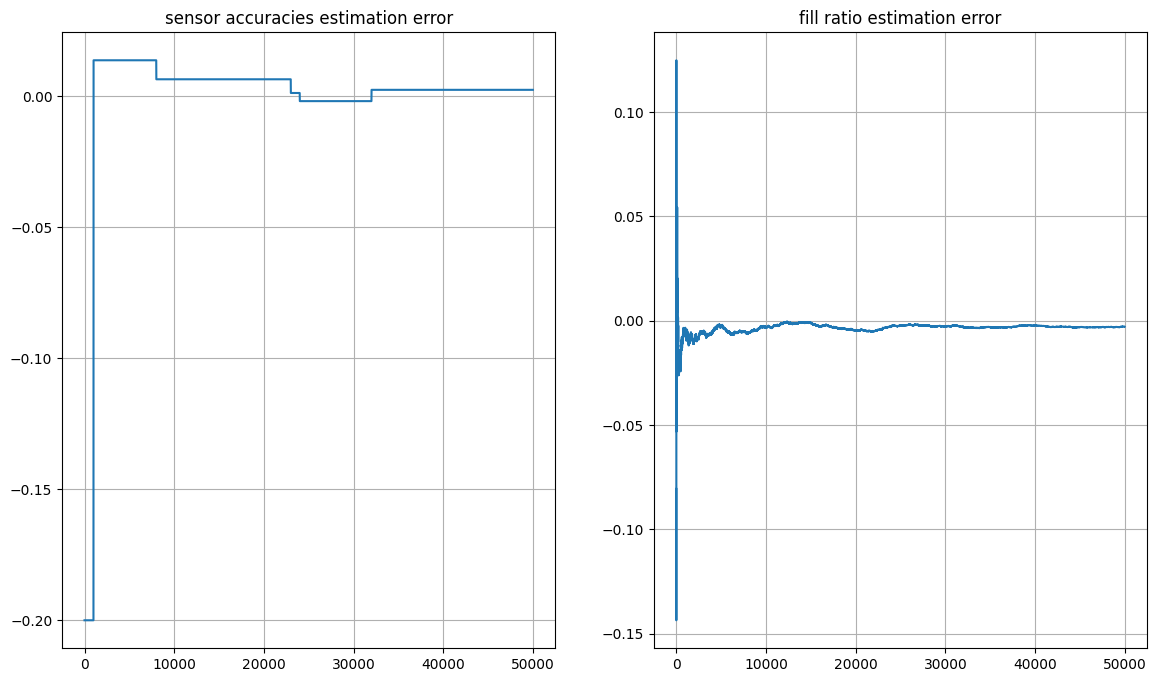

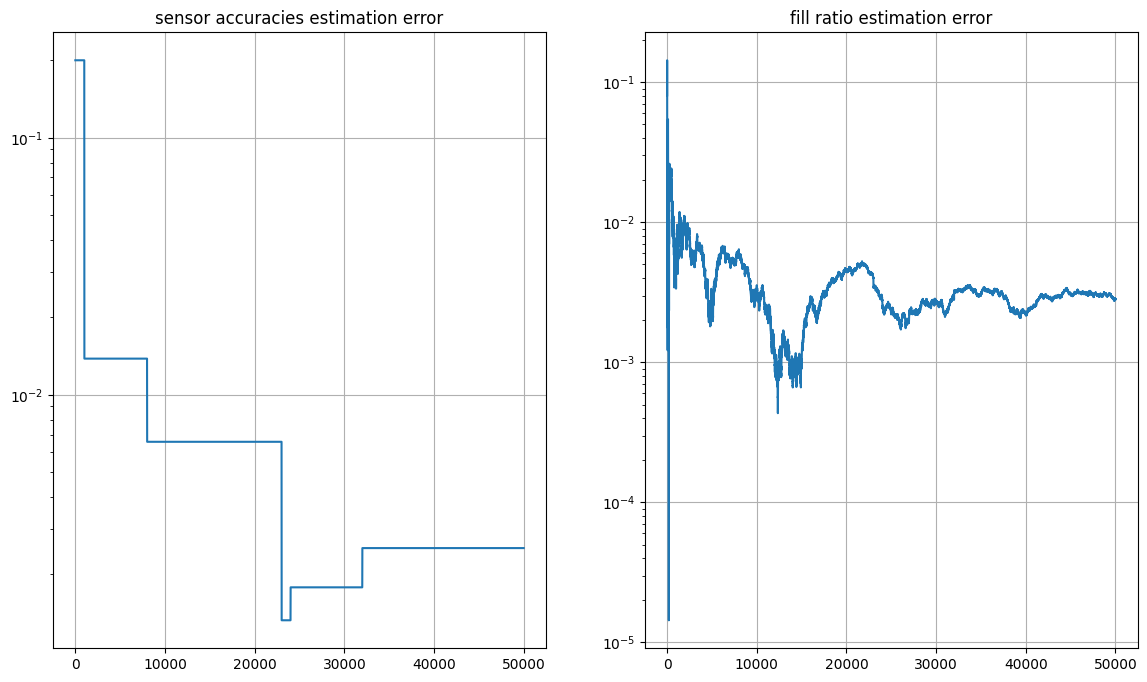

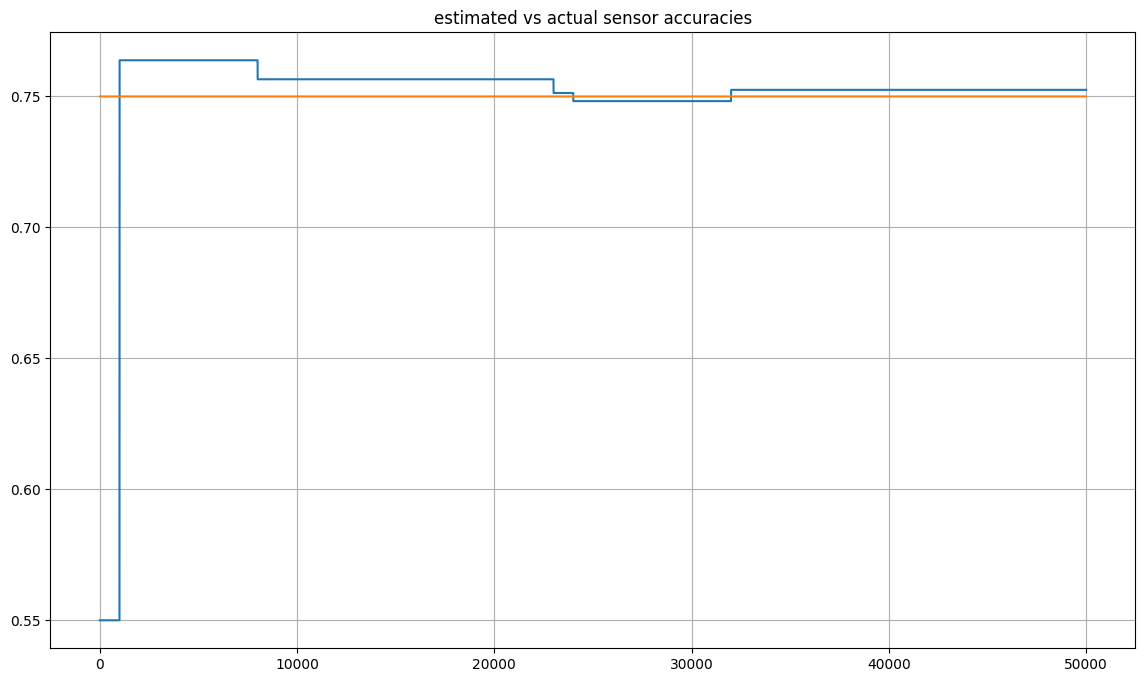

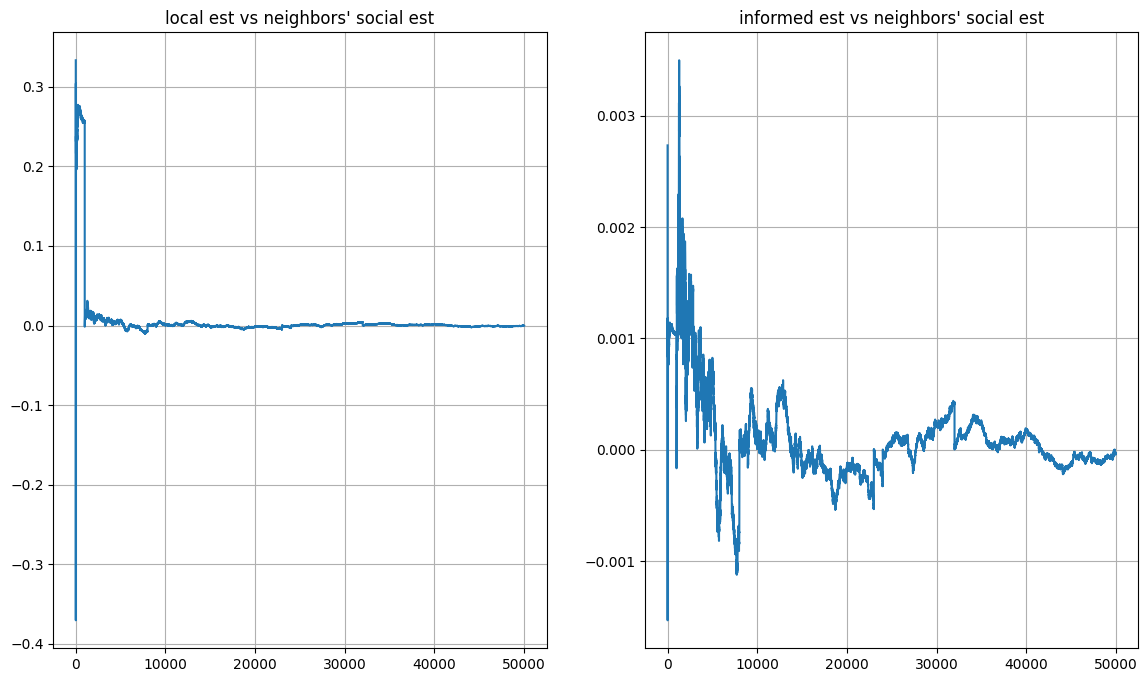

In [3]:
# Instantiate robot class
flawed_robots = []
for i in range(num_flawed_robots):
    flawed_robots.append(srsm.RobotStaticDegradation(
        "BRAVO",
        np.array([[act_b],[act_w]]),
        np.array([[init_b],[init_w]]), # assuming that we know what it starts out very well
        np.array([[0],[0]]), # assuming we have high certainty what it is
        0.1
    ))

# Define data containers
act_sensor_b_values = [np.zeros(T) for _ in range(num_flawed_robots)]
act_sensor_w_values = [np.zeros(T) for _ in range(num_flawed_robots)]
est_sensor_b_values = [np.zeros(T) for _ in range(num_flawed_robots)]
est_sensor_w_values = [np.zeros(T) for _ in range(num_flawed_robots)]
est_sensor_b_covar = [np.zeros(T) for _ in range(num_flawed_robots)]
est_sensor_w_covar = [np.zeros(T) for _ in range(num_flawed_robots)]
local_est_values = [np.zeros(T) for _ in range(num_flawed_robots)]
social_est_values = [np.zeros(T) for _ in range(num_flawed_robots)]
informed_est_values = [np.zeros(T) for _ in range(num_flawed_robots)]

# Define selection probability (based on binomial because of its right skewness)
p = 0.1 # so that we get a right skew
num_neighbor_selection_others = stats.binom(num_others, p)
num_neighbor_selection_flawed = stats.binom(num_flawed_robots, p)

# Simulate observation for all the robots
other_robots = [srsm.MinimalisticCollectivePerception() for _ in range(num_others)]
other_n = [0 for _ in range(num_others)]

figures = [0 for _ in range(int(T/sensor_filter_activation_interval))]
axes = [0 for _ in range(int(T/sensor_filter_activation_interval))]
flawed_local_est = [0 for _ in range(num_flawed_robots)]

# Run the experiment for T steps
for t in range(1, T+1):

    # Have other robots make observations
    other_n = [
        other_n[i] + other_robots[i].make_observation(occurrences[i][t-1], act_b, act_w) for i in range(num_others)
    ]

    # Do local estimation
    [robot.compute_local_estimate(occurrence=occurrences[-1][t-1]) for robot in flawed_robots]

    # Get the local estimates of the flawed robots
    flawed_local_est = [robot.get_local_estimate() for robot in flawed_robots]

    # Iterate through flawed robots to do social estimation
    for ind, robot in enumerate(flawed_robots):

        # Select a random number of robots to communicate with
        # rand_selected_quantity_others = num_neighbor_selection_others.rvs(size=1)
        rand_selected_quantity_others = num_others

        x_hat_arr = ()
        alpha_arr = ()
        x_hat_flawed = ()
        alpha_flawed = ()

        if rand_selected_quantity_others > 0 :

            # other_indices = np.random.randint(0, num_others, rand_selected_quantity_others)
            other_indices = range(0, num_others)

            # Do local estimation for selected robots
            other_local_est = [
                other_robots[ind].local_estimate(
                    gm.Observation(other_n[ind], t), act_b, act_w
                ) for ind in other_indices
            ]
            x_hat_arr, alpha_arr = zip(*other_local_est)

        if num_flawed_robots > 0:

            if fully_connected:
                # Do social estimation from selected robots
                if num_flawed_robots < 2:
                    x_hat_flawed, alpha_flawed = (), ()
                else:
                    x_hat_flawed, alpha_flawed = zip(*[est_conf_tuple for i, est_conf_tuple in enumerate(flawed_local_est) if i != ind])
                robot.compute_social_estimate(x_hat_arr+x_hat_flawed, alpha_arr+alpha_flawed)
            else:

                # flawed_indices = np.random.randint(0, num_others, rand_selected_quantity_flawed)
                flawed_indices = range(0, num_others)
                x_hat_flawed, alpha_flawed = zip(*[est_conf_tuple for i, est_conf_tuple in enumerate(flawed_local_est) if i != ind and i in flawed_indices])
                robot.compute_social_estimate(x_hat_arr+x_hat_flawed, alpha_arr+alpha_flawed)


    # Do informed estimation
    [robot.compute_informed_estimate() for robot in flawed_robots]

    # Estimate sensor filter sequentially
    if t % sensor_filter_activation_interval == 0:
        print("t = {0}: Estimating sensor quality...".format(t))
        mean_res = [robot.run_sensor_degradation_filter() for robot in flawed_robots]

    # Log sensor quality
    for ind, robot in enumerate(flawed_robots):
        act_vals = robot.get_act_sensor_quality()
        est_vals = robot.get_est_sensor_quality()
        act_sensor_b_values[ind][t-1] = act_vals[0,0]
        act_sensor_w_values[ind][t-1] = act_vals[1,0]
        est_sensor_b_values[ind][t-1] = est_vals.x[0,0]
        est_sensor_w_values[ind][t-1] = est_vals.x[1,0]
        est_sensor_b_covar[ind][t-1] = est_vals.covar[0,0]
        est_sensor_w_covar[ind][t-1] = est_vals.covar[1,0]
        local_est_values[ind][t-1], _ = robot.get_local_estimate()
        social_est_values[ind][t-1], _ = robot.get_social_estimate()
        informed_est_values[ind][t-1] = robot.get_informed_estimate()


# Plot deviation
fig1, ax1 = plt.subplots(1,2, figsize=(14, 8))
fig2, ax2 = plt.subplots(1,2, figsize=(14, 8))
for i in range(num_flawed_robots):
    
    ax1[0].plot(
        np.arange(0, T), (est_sensor_b_values[i]-act_sensor_b_values[i])
    )
    ax1[1].plot(
        np.arange(0, T), (informed_est_values[i]-act_fill_ratio)
    )
    
    ax2[0].semilogy(
        np.arange(0, T), abs(est_sensor_b_values[i]-act_sensor_b_values[i])
    )
    ax2[1].semilogy(
        np.arange(0, T), abs(informed_est_values[i]-act_fill_ratio)
    )

ax1[0].set_title("sensor accuracies estimation error")
ax1[1].set_title("fill ratio estimation error")
ax1[0].grid()
ax1[1].grid()
ax2[0].set_title("sensor accuracies estimation error")
ax2[1].set_title("fill ratio estimation error")
ax2[0].grid()
ax2[1].grid()

# Plot sensor degradation
fig3, ax3 = plt.subplots(figsize=(14, 8))

for i in range(num_flawed_robots):
    ax3.plot(
        np.arange(0, T), est_sensor_b_values[i],
        np.arange(0, T), act_sensor_b_values[i]
    )
ax3.grid()
ax3.set_title("estimated vs actual sensor accuracies")

# Plot self fill ratio estimate vs neighbors' estimates
fig4, ax4 = plt.subplots(1,2,figsize=(14, 8))
for i in range(num_flawed_robots):

    ax4[0].plot(
        np.arange(0, T), local_est_values[i] - social_est_values[i]
    )
    ax4[1].plot(
        np.arange(0, T), informed_est_values[i] - social_est_values[i]
    )

ax4[0].set_title("local est vs neighbors' social est")
ax4[1].set_title("informed est vs neighbors' social est")
ax4[0].grid()
ax4[1].grid()
